In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from arch import arch_model  # Modelos GARCH
from statsmodels.tsa.seasonal import seasonal_decompose  # Descomposición (Tendencia, Estacionalidad)
from statsmodels.tsa.stattools import adfuller          # Test de Dickey-Fuller (Estacionariedad)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Correlación
from statsmodels.tsa.statespace.sarimax import SARIMAX  # El modelo "todoterreno"



In [2]:
df = yf.download('AMD', start='2024-01-01')
precios = df['Close']

[*********************100%***********************]  1 of 1 completed


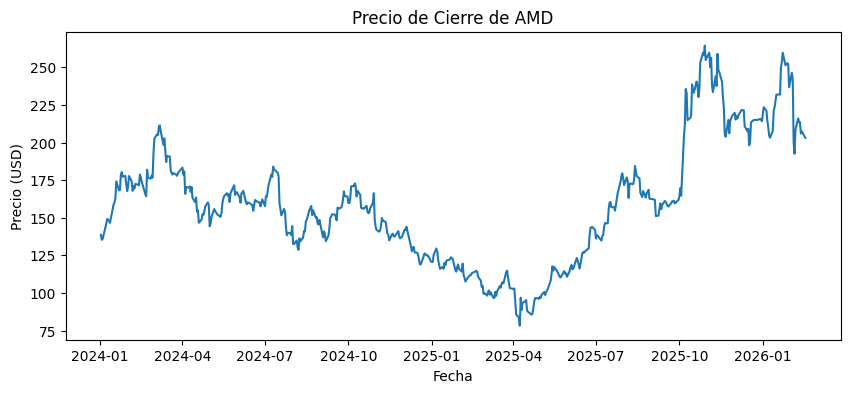

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(precios, label='Precio de Cierre')
plt.title('Precio de Cierre de AMD')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.show()

In [4]:
# calculamos los log-retornos
df['Log_Retornos']  = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)  # Eliminamos el primer valor que es NaN

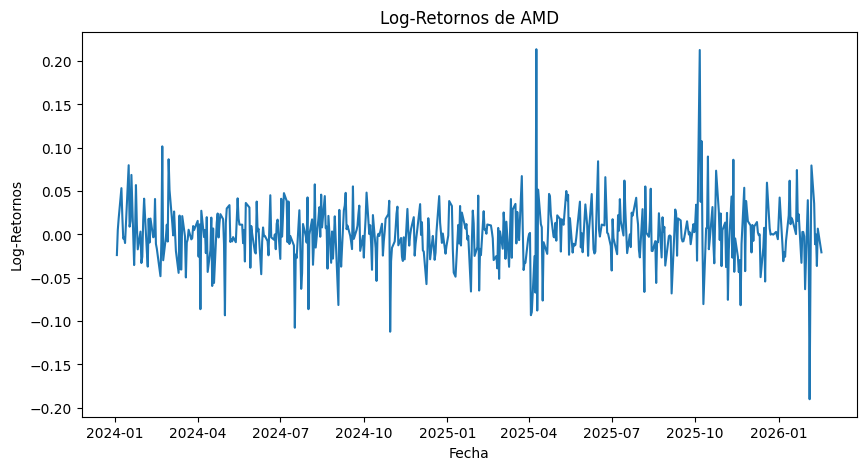

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Log_Retornos'], label='Log-Retornos')
plt.title('Log-Retornos de AMD')
plt.xlabel('Fecha')
plt.ylabel('Log-Retornos')
plt.show()

In [ ]:
adfuller_result = adfuller(df['Log_Retornos'])
print(f'p-value del test de Dickey-Fuller: {adfuller_result[1]}')


p-value del test de Dickey-Fuller: 0.0


In [ ]:
# el p-value es muy bajo, lo que indica que los log-retornos son estacionarios. Esto es un requisito fundamental para aplicar modelos GARCH.
# Ahora, vamos a analizar la volatilidad de los log-retornos. Para esto, calculamos los log-retornos al cuadrado y los log-retornos absolutos.
log_retornos = df['Log_Retornos']
log_ret_sq = log_retornos**2
log_ret_abs = log_retornos.abs()
# de esta forma calculamos los retornos al cuadrado y los retornos absolutos, que son útiles para analizar la volatilidad.
# y a la vez nos permiten detectar dependencia no lineal.

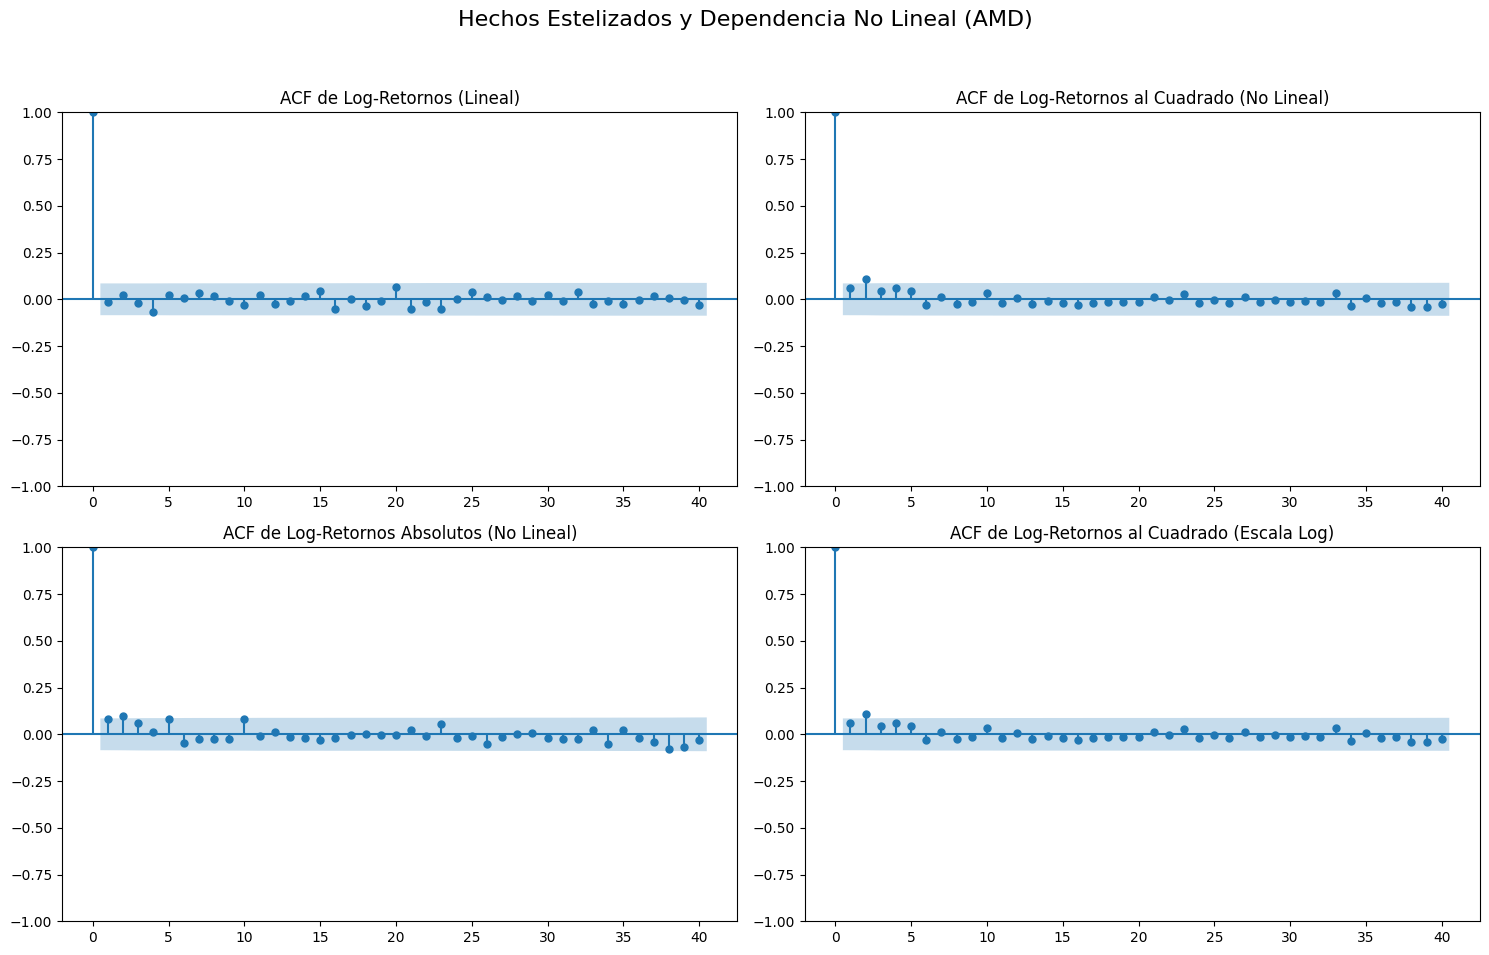

In [7]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Hechos Estelizados y Dependencia No Lineal (AMD)', fontsize=16)

#Grafico 1 ACF de Log-Retornos
plot_acf(log_retornos, ax=axes[0,0], lags = 40, title='ACF de Log-Retornos (Lineal)')
#Grafico 2 ACF de Log-Retornos al Cuadrado
plot_acf(log_ret_sq, ax=axes[0,1], lags = 40, title='ACF de Log-Retornos al Cuadrado (No Lineal)')
#Grafico 3 ACF de Log-Retornos Absolutos
plot_acf(log_ret_abs, ax=axes[1,0], lags = 40, title='ACF de Log-Retornos Absolutos (No Lineal)')
#Grafico 4 ACF de Log-Retornos al Cuadrado con escala logarítmica
plot_acf(log_ret_sq, ax=axes[1,1], lags = 40, title='ACF de Log-Retornos al Cuadrado (Escala Log)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
#Se puede observar que los Log-Retornos no presentan autocorrelación lineal, pero sí muestra 
#Dependencia No Lineal, en los Absolutos y al Cuadrado, por lo tanto es adecuado aplicar un modelo GARCH para modelar la volatilidad de los log-retornos de AMD.
model= arch_model(df['Log_Retornos']*100, vol='Garch', p= 1, q = 1, dist= 'normal')

res = model.fit(update_freq= 5)
print(res.summary()) 

Iteration:      5,   Func. Count:     32,   Neg. LLF: 1406.9647082054184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1406.9647020718094
            Iterations: 7
            Function evaluations: 41
            Gradient evaluations: 7
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Log_Retornos   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1406.96
Distribution:                  Normal   AIC:                           2821.93
Method:            Maximum Likelihood   BIC:                           2839.04
                                        No. Observations:                  532
Date:                Wed, Feb 18 2026   Df Residuals:                      531
Time:                        01:48:21   Df Model:                            1
        

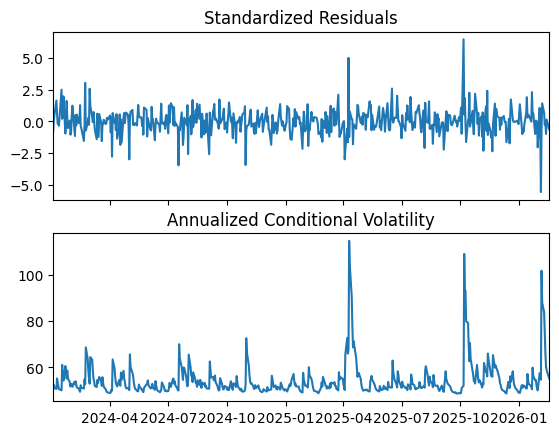

In [11]:
fig= res.plot(annualize='D') 
plt.show()


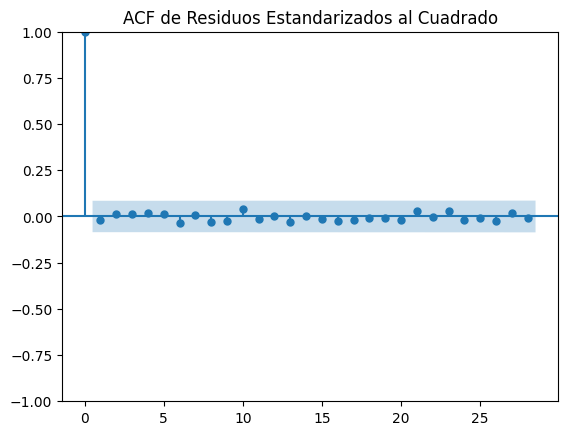

In [13]:
residuos_est = res.resid / res.conditional_volatility

plot_acf(residuos_est**2)
plt.title('ACF de Residuos Estandarizados al Cuadrado')
plt.show()

In [ ]:
# se comprueba  que no hay autocorrelación en los residuos estandarizados al cuadrado,
# lo que indica que el modelo GARCH(1,1) ha capturado adecuadamente la volatilidad de los log-retornos de AMD.
# por lo que se puede confiar en las proyecciones de volatilidad que nos brinda el modelo para los próximos días.
# forescasting
forecasts = res.forecast(horizon=5) # horizon = 5 días

vol_forecast = np.sqrt(forecasts.variance.values[-1,:])

dias= ['D+1', 'D+2', 'D+3', 'D+4', 'D+5']
for d, v in zip(dias, vol_forecast):
    print(f"Volatilidad proyectada para {d}: {v:.6f}")

Volatilidad proyectada para D+1: 3.389386
Volatilidad proyectada para D+2: 3.410796
Volatilidad proyectada para D+3: 3.425998
Volatilidad proyectada para D+4: 3.436809
Volatilidad proyectada para D+5: 3.444506


In [20]:
# VaR al 95% para el próximo día
posicion = 1_000_000 
vol_mañana = vol_forecast[0] / 100  # Convertimos de porcentaje a decimal
media = res.params['mu'] / 100  # Convertimos de porcentaje a decimal
var_95 = posicion * (media - 1.65 * vol_mañana)
print(f"Al 95% de confianza, la pérdida máxima para mañana es: ${abs(var_95):,.0f}")

Al 95% de confianza, la pérdida máxima para mañana es: $54,756
